### Downloading Dataset from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("choongqianzheng/disease-and-symptoms-dataset")

print("Path to dataset files:", path)

100%|██████████| 24.1k/24.1k [00:00<00:00, 23.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/choongqianzheng/disease-and-symptoms-dataset/versions/2


In [2]:
!ls /root/.cache/kagglehub/datasets/choongqianzheng/disease-and-symptoms-dataset/versions/2

 DiseaseAndSymptoms.csv  'Disease precaution.csv'


In [3]:
!pip install -q transformers datasets peft bitsandbytes accelerate trl kaggle scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 29.3 MB/s eta 0:00:00


### Importing necessary libraries

In [4]:
import os
import pandas as pd
import json, random
from sklearn.model_selection import train_test_split
import re
import json
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tqdm

import torch
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

In [5]:
joined_path = os.path.join(path, 'DiseaseAndSymptoms.csv')
df = pd.read_csv(joined_path)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### JSONL creation

In [6]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

def format_row(row):
    symptoms = ", ".join([str(row[col]) for col in df.columns[1:] if pd.notna(row[col])])
    disease = row['Disease']
    return {
        "instruction": "Identify the disease pattern based on symptoms.",
        "input": symptoms,
        "output": f"Disease: {disease}\nExplanation: These symptoms frequently match {disease} patterns in the dataset.\nNote: This is not medical advice."
    }

with open("train.jsonl", "w") as f:
    for _, row in train_df.iterrows():
        json.dump(format_row(row), f)
        f.write("\n")

with open("test.jsonl", "w") as f:
    for _, row in test_df.iterrows():
        json.dump(format_row(row), f)
        f.write("\n")


### Downloading model checkpoints form Huggingface

In [7]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    dtype=torch.float16
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Lora Configuration

In [8]:
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.0,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 563,200 || all params: 1,100,611,584 || trainable%: 0.0512


### Loading training data

In [9]:
dataset = load_dataset("json", data_files={"train":"train.jsonl"})

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
def format_prompt(example):
    return {
        "text": f"""### Instruction:
{example['instruction']}

### Input:
{example['input']}

### Response:
{example['output']}"""
    }

dataset = dataset.map(format_prompt)


Map:   0%|          | 0/4428 [00:00<?, ? examples/s]

### Using SFTTrainer for Fine tuning

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    logging_steps=10,
    save_strategy="epoch",
    fp16=True
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    args=training_args
)

trainer.train()

Adding EOS to train dataset:   0%|          | 0/4428 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4428 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4428 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
10,2.495900
20,2.357000
30,2.254600
40,2.127900
50,2.038400
60,1.937700
70,1.739600
80,1.613200
90,1.422500
100,1.258600


wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run


TrainOutput(global_step=2214, training_loss=0.3368078014445714, metrics={'train_runtime': 1093.6072, 'train_samples_per_second': 8.098, 'train_steps_per_second': 2.024, 'total_flos': 6967097896206336.0, 'train_loss': 0.3368078014445714, 'entropy': 0.19919362291693687, 'num_tokens': 1013052.0, 'mean_token_accuracy': 0.9766100868582726, 'epoch': 2.0})

### Saving fine tuned model checkpoints

In [12]:
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/chat_template.jinja',
 'fine_tuned_model/tokenizer.model',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

### Testing model on test data

In [31]:
true_labels = []
pred_labels = []

with open("test.jsonl") as f:
    total_lines = sum(1 for _ in f)

with open("test.jsonl") as f:
    for line in tqdm.tqdm(f, total=total_lines, desc="Processing samples"):
        item = json.loads(line)
        true = item["output"].split("\n")[0].replace("Disease: ","")

        prompt = f"""### Instruction:
{item['instruction']}

### Input:
{item['input']}

### Response:
"""

        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens=100)
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        match = re.search(r"Disease:\s*(.*)", text)
        pred = match.group(1).strip() if match else "Unknown"

        true_labels.append(true)
        pred_labels.append(pred)


Processing samples: 100%|██████████| 492/492 [21:36<00:00,  2.63s/it]


### Confusion matrix

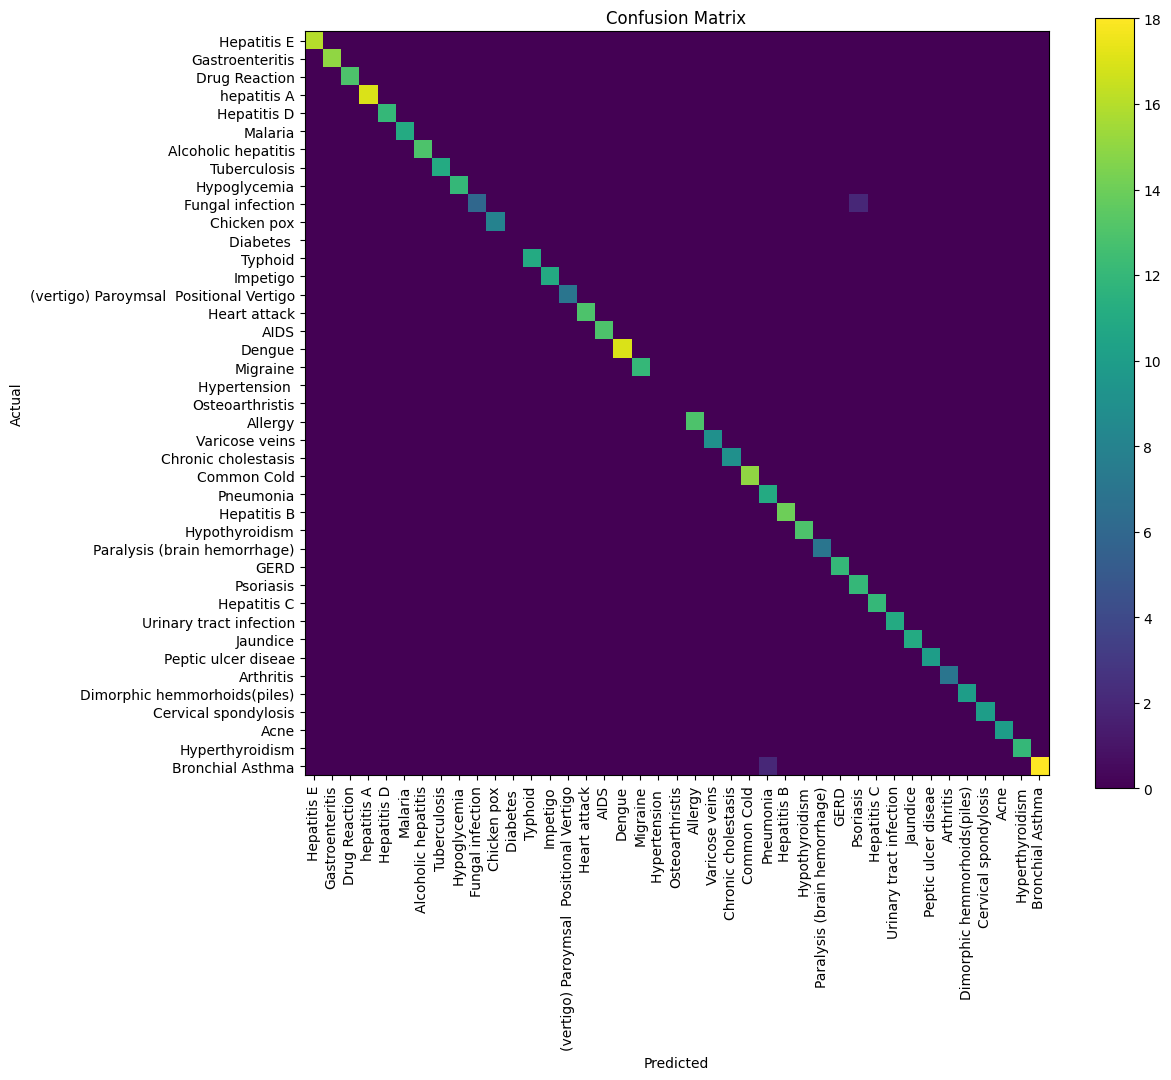

In [32]:
labels = list(set(true_labels))

cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(12,10))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.savefig("confusion_matrix.png")
plt.show()


### Demo query

In [33]:
query = """### Instruction:
Identify the disease pattern based on symptoms.

### Input:
Fever, headache, body pain

### Response:
"""

inputs = tokenizer(query, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=150)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


### Instruction:
Identify the disease pattern based on symptoms.

### Input:
Fever, headache, body pain

### Response:
Disease: Typhoid (Globe)
Explanation: These symptoms frequently match Typhoid (Globe) patterns in the dataset.
Note: This is not medical advice.


### 3 Test queries

In [44]:
def predict_disease_pattern(symptoms, tokenizer, model, device="cuda"):
    query = f"""### Instruction:
Identify the disease pattern based on symptoms.

### Input:
{symptoms}

### Response:
"""

    inputs = tokenizer(query, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=150)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [45]:
result = predict_disease_pattern(
    symptoms="Cough, shortness of breath, chest tightness",
    tokenizer=tokenizer,
    model=model
)

print(result)

### Instruction:
Identify the disease pattern based on symptoms.

### Input:
Cough, shortness of breath, chest tightness

### Response:
Disease: Drug addiction
Explanation: These symptoms frequently match Drug addiction patterns in the dataset.
Note: This is not medical advice.


In [46]:
result = predict_disease_pattern(
    symptoms="Frequent urination, excessive thirst, unexplained weight loss",
    tokenizer=tokenizer,
    model=model
)

print(result)

### Instruction:
Identify the disease pattern based on symptoms.

### Input:
Frequent urination, excessive thirst, unexplained weight loss

### Response:
Disease: Hypertension
Explanation: These symptoms frequently match Hypertension patterns in the dataset.
Note: This is not medical advice.


In [47]:
result = predict_disease_pattern(
    symptoms="Rash, joint pain",
    tokenizer=tokenizer,
    model=model
)

print(result)

### Instruction:
Identify the disease pattern based on symptoms.

### Input:
Rash, joint pain

### Response:
Disease: Arthritis
Explanation: These symptoms frequently match Arthritis patterns in the dataset.
Note: This is not medical advice.
